# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Импорты

In [1]:
import warnings
import re
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier

### Загружаем данные

In [2]:
df = pd.read_csv('Churn.csv')

### Общая информация о датасете

In [3]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Пропуски только в стобце Tenure. Однако их мало. При обработке можно выкинуть эти строки. Типы данных соответствуют содержимому.

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Первые пять строк выглядят нормально. Выведем описательную статистику.

In [5]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Количественные признаки требуют нормализации. Выбросы есть, но нельзя сказать, что они саязаны с ошибками ввода данных.

### Переименование столбцов (приведение к snake_case)

In [6]:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower().strip()
df.columns = pd.Index([camel_to_snake(x) for x in df.columns])
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

### Борьба с дубликатами

In [7]:
df.duplicated().sum()

0

Полных дубликатов нет

### Очистка от NaN значений

In [8]:
df = df.dropna().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        9091 non-null   int64  
 1   customer_id       9091 non-null   int64  
 2   surname           9091 non-null   object 
 3   credit_score      9091 non-null   int64  
 4   geography         9091 non-null   object 
 5   gender            9091 non-null   object 
 6   age               9091 non-null   int64  
 7   tenure            9091 non-null   float64
 8   balance           9091 non-null   float64
 9   num_of_products   9091 non-null   int64  
 10  has_cr_card       9091 non-null   int64  
 11  is_active_member  9091 non-null   int64  
 12  estimated_salary  9091 non-null   float64
 13  exited            9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 994.5+ KB


Потеряли 9 строчек.

### Анализ признаков и обработка

Первые три столбца не важны для анализа. Их можно удалить.

In [9]:
df = df.iloc[:,4:]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   geography         9091 non-null   object 
 1   gender            9091 non-null   object 
 2   age               9091 non-null   int64  
 3   tenure            9091 non-null   float64
 4   balance           9091 non-null   float64
 5   num_of_products   9091 non-null   int64  
 6   has_cr_card       9091 non-null   int64  
 7   is_active_member  9091 non-null   int64  
 8   estimated_salary  9091 non-null   float64
 9   exited            9091 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 710.4+ KB


#### Категориальные признаки

Категориальные признаки: Geography, Gender, HasCrCard, IsActiveMember. Причём кодировать нужно только 2 из них. Но сначала можно посмотреть на распределения их в выборке.

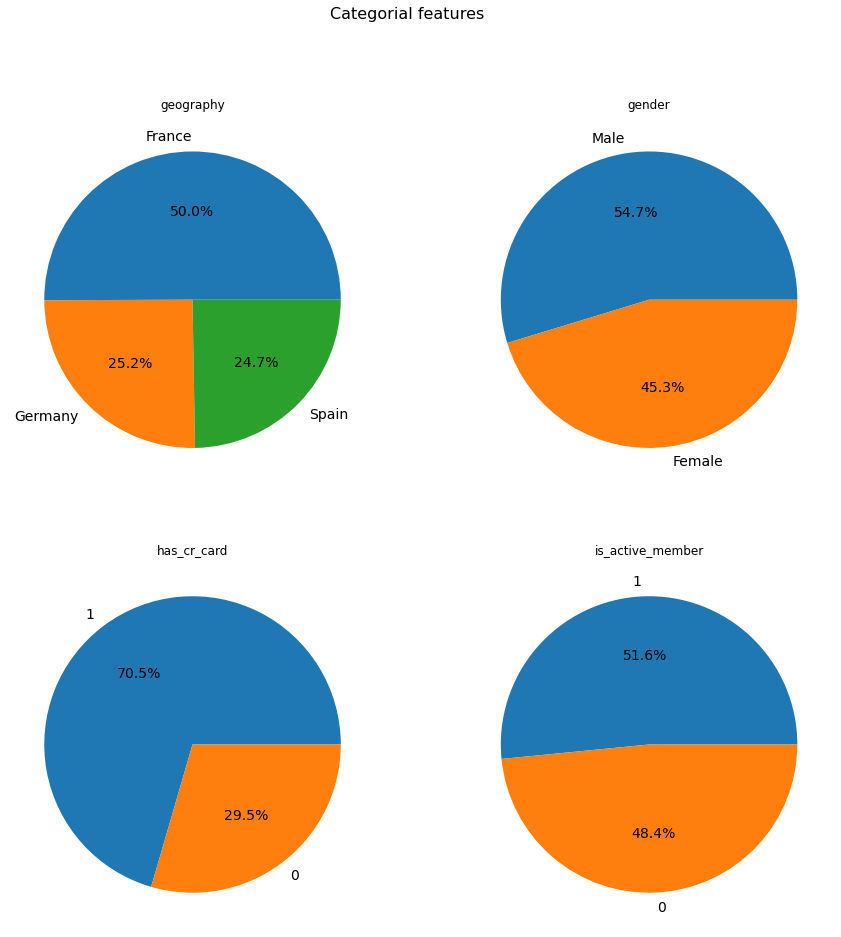

In [10]:
cat_features = ['geography', 'gender', 'has_cr_card', 'is_active_member']
fig, axes = plt.subplots(2, 2, figsize=(15,15));
fig.suptitle("Categorial features", fontsize=16)
axes = axes.ravel()
for i, cat in enumerate(cat_features):
    df.groupby(cat)[cat].count().sort_values(ascending=False).plot(kind='pie', title=cat, ax=axes[i], fontsize=14, autopct='%1.1f%%') 
    axes[i].set_ylabel(None)

К двум категориальным признакам применим метод OHE с избеганием Dummy-ловушки. Этот метод применим, как в моделях основанных на решающих деревьях, так и к линейным моделям.

In [11]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


#### Количественные признаки

In [12]:
num_features = ['age', 'tenure', 'balance','num_of_products', 'estimated_salary']

##### Проверка матрицы диаграмм рассеяния

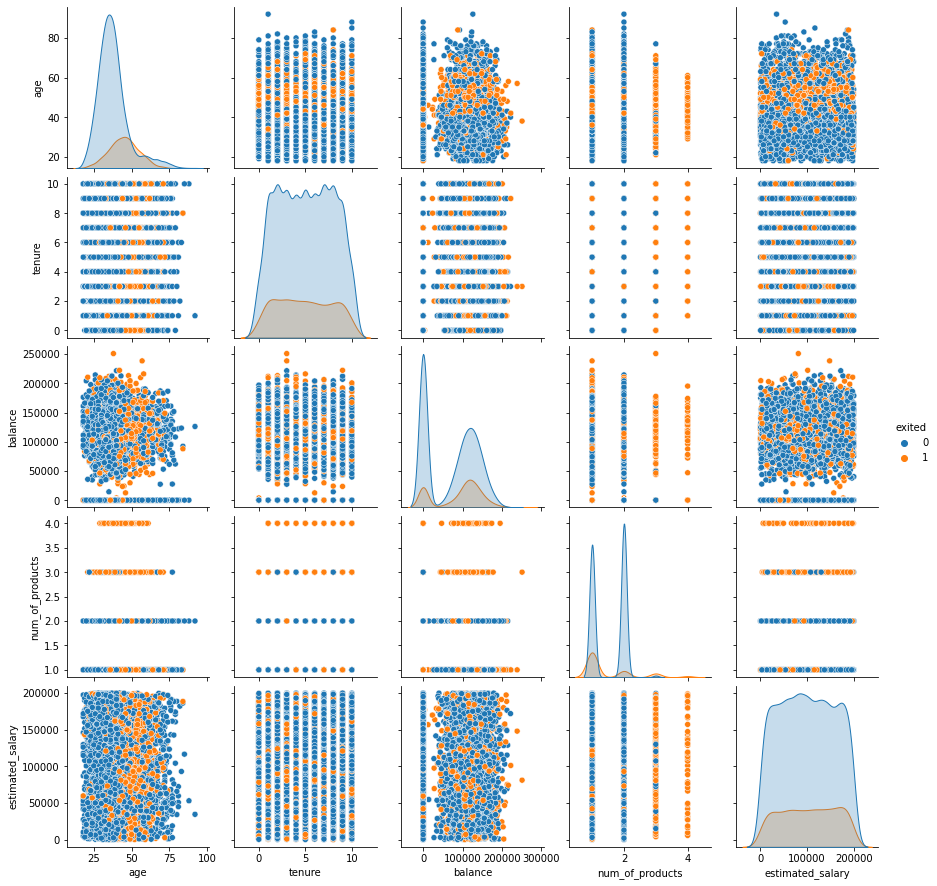

In [13]:
sns.pairplot(df.loc[:,num_features+["exited"]], hue="exited");

Сильных корреляций признаков и мультиколинеарности не наблюдается.

#### Разделение данных на признаки и целевую переменную

In [14]:
target = df["exited"]
features = df.drop(['exited'], axis=1)

#### Выделение тестового набора

In [15]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                          test_size=0.2,
                                                                          random_state=12345)
features_train = features_train.reset_index(drop=True)
features_test = features_test.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)
print(features_train.shape) 
print(features_test.shape) 
print(target_train.shape)
print(target_test.shape)

(7272, 10)
(1819, 10)
(7272,)
(1819,)


### Шкалирование количественных признаков

In [16]:
scaler = StandardScaler()
features_train.loc[:,num_features] = pd.DataFrame(data=scaler.fit_transform(features_train.loc[:,num_features]),
                                              columns=features_train.loc[:,num_features].columns)
features_test.loc[:,num_features] = pd.DataFrame(data=scaler.transform(features_test.loc[:,num_features]),
                                             columns=features_test.loc[:,num_features].columns)
features_train.head()

,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
0,-0.755896,1.032080,-1.235435,0.806573,1,0,1.351774,0,0,1
1,1.609084,-0.688132,1.249209,-0.909459,0,1,0.257662,0,1,1
2,0.757691,-0.344090,0.358445,0.806573,1,1,0.373276,1,0,0
3,0.190096,-0.000047,1.117429,0.806573,0,0,1.391016,0,1,1
4,-0.566697,-1.720259,1.682729,-0.909459,1,1,0.122738,1,0,1


Шкалирование признаков выполнено.

## Исследование задачи

### Выбор моделей

В задаче не сказано какие модели рассматривать. Рассмотрим разные модели по скорости обучения и приципу работы.
1. Классификатор на основе метода k ближайших соседей.
2. Логистическая регрессия.
3. Одиночное решающее дерево.
4. Случайный лес.

Подбирать наиболее важные гиперпараметры будем используя GridSearchCV. Поэтому валидационная выборка нам не нужна. В качестве целевой функции будем использовать f1 меру.

### Распределение классов целевой переменной

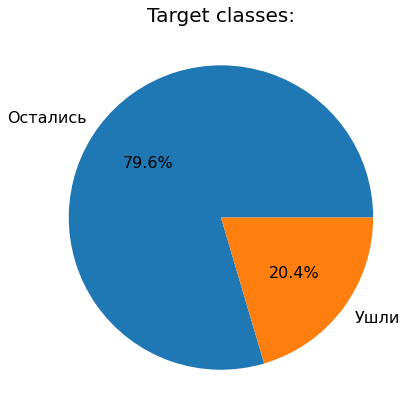

In [17]:
fig = target_train.value_counts().rename(index={1:"Ушли", 0:"Остались"}).plot(kind='pie', 
                                            title="Target classes:",
                                            fontsize=16,
                                            legend=False,
                                            autopct='%1.1f%%',
                                            figsize=(7,7))
fig.axes.title.set_size(20)
fig.axes.set_ylabel(None);

Присутствует сильный дисбаланс классов. Однако, по-заданию, попробуем обучить модели сначала без учета дисбаланса.

### Определение базовой линии

In [18]:
model_bl = DummyClassifier()
model_bl.fit(features_train, target_train)
score = model_bl.score(features_train, target_train)
print(f"The baseline accurancy: {score:.2%}")
predicted_train = model_bl.predict(features_train)
print(f"The baseline F1-score: {f1_score(target_train, predicted_train):.2%}")

The baseline accurancy: 79.58%
The baseline F1-score: 0.00%


Что и следовало ожидать при дисбалансе классов достаточно для высокой accurancy просто давать метку самого популярного класса, но с F1 мерой такой трюк не проходит.

### Метод k-ближайших соседей

Метод прост для понимание и быстро обучается из за того, что процесс обучения в сущности состоит из запоминания обучающего набора. Есть один самый важный гиперпараметр: число соседей.При маленьком числе соседей имеет склонность к переобучению.

In [19]:
parameters = {'n_neighbors':list(range(1,20))}
model = KNeighborsClassifier()
clf_knn = GridSearchCV(model, parameters, scoring='f1')
clf_knn.fit(features_train, target_train)
print(f"The best f1-score: {clf_knn.best_score_:.2%} for n_neighbors: {clf_knn.best_params_['n_neighbors']}")

The best f1-score: 54.23% for n_neighbors: 13


Неплохой результат.

### Логистическая регрессия

Метод тоже достаточно быстрый и надежный. Но у него линейная граница принятия решений. Будем подбирать параметр регуляризации (C). Так как у него по инструкции логарифмическая шкала то воспользуемся logspace.

In [20]:
parameters = {"random_state":[12345], 'C':list(np.logspace(-3, 4, 8))}
model = LogisticRegression()
clf_lr = GridSearchCV(model, parameters, scoring='f1')
clf_lr.fit(features_train, target_train)
print(f"The best f1-score: {clf_lr.best_score_:.2%} for C: {clf_lr.best_params_['C']}")


The best f1-score: 29.92% for C: 10.0


Плохо.

### Решающее дерево

Из всех гиперпараметров будем подбирать один из самых важных: максимальную высоту дерева. При низкой высоте дерево склонно к недобучению, а при слишком высокой - переобучению.

In [21]:
parameters = {"random_state":[12345], 'max_depth':list(range(1, 20))}
model = DecisionTreeClassifier()
clf_dt = GridSearchCV(model, parameters, scoring='f1')
clf_dt.fit(features_train, target_train)
print(f"The best f1-score: {clf_dt.best_score_:.2%} for max_depth: {clf_dt.best_params_['max_depth']}")

The best f1-score: 56.39% for max_depth: 7


Результат близок к необходимому и без учёта дисбаланса, но недостаточно хорош.

### Случайный лес

Самая медленная модель. Будем перебирать два параметра: количество деревьев и максимальную глубину каждого дерева.

In [22]:
parameters = {"random_state":[12345], 
              'max_depth':list(range(1, 15)), 
              'n_estimators':[50, 100, 200, 350]}
model = RandomForestClassifier()
clf_rf = GridSearchCV(model, parameters, scoring='f1', n_jobs=-1)
clf_rf.fit(features_train, target_train)
print(f"The best f1-score: {clf_rf.best_score_:.2%} for max_depth:" 
      f"{clf_rf.best_params_['max_depth']} and n_estimators: {clf_rf.best_params_['n_estimators']}")

The best f1-score: 57.34% for max_depth:13 and n_estimators: 50


Результат близок к необходимому и без учёта дисбаланса, но недостаточно хорош.

### Сравнение лучших моделей по F1

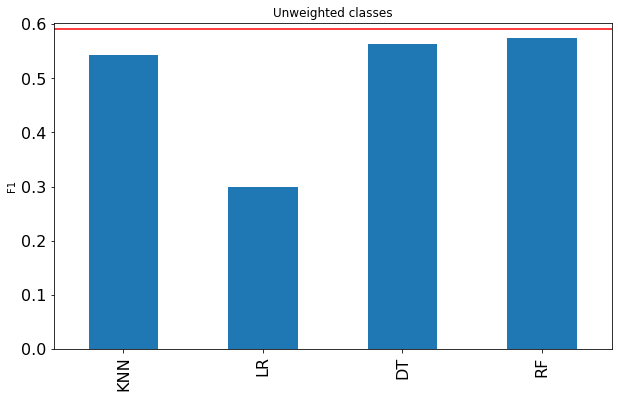

In [23]:
fig = pd.Series(data=[clf_knn.best_score_,
                clf_lr.best_score_,
                clf_dt.best_score_,
                clf_rf.best_score_],
                index=['KNN','LR','DT', 'RF']).plot(kind='bar', 
                                                    title="Unweighted classes",
                                                    fontsize=16,
                                                    figsize=(10,6))
fig.set_ylabel('F1');
plt.axhline(y = 0.59, color = 'r', linestyle = '-');

**Вывод** Не одна из моделей не дотягивает до целевого значения метрики. Есть и аутсайдер - логистическая регрессия.

## Борьба с дисбалансом

### Взвешивание классов
Применим веса классов для моделей, которые позволяют это сделать. И заново натренируем модели с подбором оптимальных параметров.

#### Логистическая регрессия

In [24]:
parameters = {"random_state":[12345], 'class_weight':['balanced'], 'C':list(np.logspace(-3, 4, 8))}
model = LogisticRegression()
clf_lr_w = GridSearchCV(model, parameters, scoring='f1')
clf_lr_w.fit(features_train, target_train)
print(f"The best f1-score: {clf_lr_w.best_score_:.2%} for C: {clf_lr_w.best_params_['C']}")

The best f1-score: 49.98% for C: 0.01


Лучше чем было до взвешивания, но всё равно плохо.

#### Решающее дерево

In [25]:
parameters = {"random_state":[12345], 'class_weight':['balanced'], 'max_depth':list(range(1, 20))}
model = DecisionTreeClassifier()
clf_dt_w = GridSearchCV(model, parameters, scoring='f1')
clf_dt_w.fit(features_train, target_train)
print(f"The best f1-score: {clf_dt_w.best_score_:.2%} for max_depth: {clf_dt_w.best_params_['max_depth']}")

The best f1-score: 56.23% for max_depth: 5


Значение практически не изменилось.

#### Случайный лес

In [26]:
parameters = {"random_state":[12345],
              'class_weight':['balanced'],
              'max_depth':list(range(1, 15)), 
              'n_estimators':[50, 100, 200, 350]}
model = RandomForestClassifier()
clf_rf_w = GridSearchCV(model, parameters, scoring='f1', n_jobs=-1)
clf_rf_w.fit(features_train, target_train)
print(f"The best f1-score: {clf_rf_w.best_score_:.2%} for max_depth:" 
      f"{clf_rf_w.best_params_['max_depth']} and n_estimators: {clf_rf_w.best_params_['n_estimators']}")

The best f1-score: 61.50% for max_depth:10 and n_estimators: 100


Значение выросло до значения пригодного для сдачи проекта. Но дальше будет одна забавная вещь связанная с Upsampling и кросс-валидацией.

#### Сравнение лучших моделей по F1

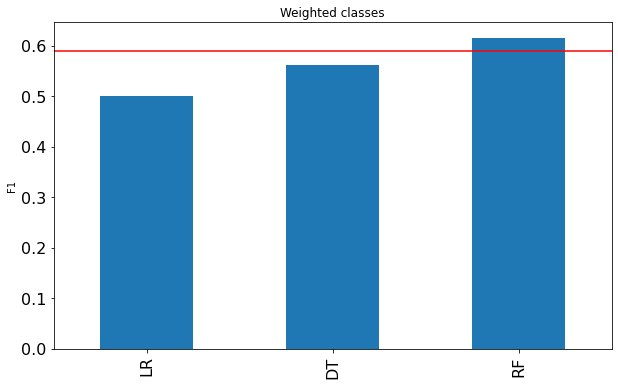

In [27]:
fig = pd.Series(data=[clf_lr_w.best_score_,
                clf_dt_w.best_score_,
                clf_rf_w.best_score_],
                index=['LR','DT', 'RF']).plot(kind='bar', 
                                                    title="Weighted classes",
                                                    fontsize=16,
                                                    figsize=(10,6))
fig.set_ylabel('F1');
plt.axhline(y = 0.59, color = 'r', linestyle = '-');

**Вывод** При использования автоматического взвешенного класса целевая метрика выросла и у случайного леса превысила порог.

### Downsampling уменьшение выборки

Точек положительного класса меньше, чем точек отрицательного в 4 раза (0.25). Случайно удалив часть выборки можно добиться баланса классов.

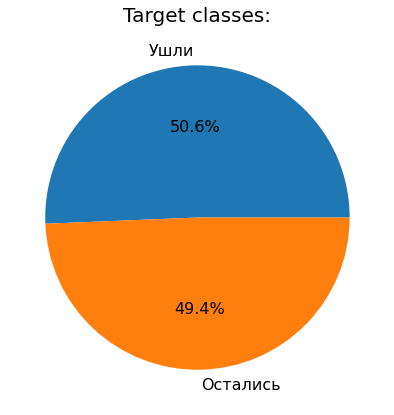

In [28]:
def downsample(features, target, fraction=0.25):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
fig = target_downsampled.value_counts().rename(index={1:"Ушли", 0:"Остались"}).plot(kind='pie', 
                                            title="Target classes:",
                                            fontsize=16,
                                            legend=False,
                                            autopct='%1.1f%%',
                                            figsize=(7,7))
fig.axes.title.set_size(20)
fig.axes.set_ylabel(None);

Дисбаланс устранён.

#### Метод k-ближайших соседей.

In [29]:
parameters = {'n_neighbors':list(range(1,20))}
model = KNeighborsClassifier()
clf_knn_d = GridSearchCV(model, parameters, scoring='f1')
clf_knn_d.fit(features_downsampled, target_downsampled)
print(f"The best f1-score: {clf_knn_d.best_score_:.2%} for n_neighbors: {clf_knn_d.best_params_['n_neighbors']}")

The best f1-score: 75.71% for n_neighbors: 19


Значимое возрастание критерия оценки. 

In [30]:
def score_model(model, params, resample_func, cv=None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if cv is None:
        cv = KFold(n_splits=5, random_state=12345, shuffle=True)
    
    scores = []
    X_train = features_train.to_numpy()
    y_train = target_train.to_numpy()
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train[train_fold_index], y_train[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train[val_fold_index], y_train[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = resample_func(pd.DataFrame(data=X_train_fold),
                                                                pd.Series(data = y_train_fold))
        # Fit the model on the upsampled training data
        model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = f1_score(y_val_fold, model_obj.predict(X_val_fold))
        scores.append(score)
    return np.array(scores)

In [31]:
score_tracker = []
parameters = {'n_neighbors':list(range(1,20))}
for n_neighbors in parameters['n_neighbors']:
    example_params = {
        'n_neighbors': n_neighbors,
    }
    example_params['f1_score'] = score_model(KNeighborsClassifier, example_params, downsample).mean()
    score_tracker.append(example_params)
        
# What's the best model?
best_knn_d = sorted(score_tracker, key=lambda x: x['f1_score'], reverse=True)[0]
best_knn_d

{'n_neighbors': 12, 'f1_score': 0.5743942993126276}

Лучше, чем при дисбалансе. Результат стал более реальным, чем при неправильной кросс-валидации при даунсамплинге.

#### Логистическая регрессия

In [32]:
parameters = {"random_state":[12345], 'C':list(np.logspace(-3, 4, 8))}
score_tracker = []
for c in parameters['C']:
    example_params = {
        'C': c,
        "random_state": 12345
    }
    example_params['f1_score'] = score_model(LogisticRegression, example_params, downsample).mean()
    score_tracker.append(example_params)
        
# What's the best model?
best_lr_d = sorted(score_tracker, key=lambda x: x['f1_score'], reverse=True)[0]
best_lr_d

{'C': 0.01, 'random_state': 12345, 'f1_score': 0.4928863684467119}

Уменьшение выборки лучшим образом сказались на качестве модели, но это не самая лучшая модель.

#### Решающее дерево

In [33]:
parameters = {"random_state":[12345], 'max_depth':list(range(1, 20))} 
score_tracker = []
for max_depth in parameters['max_depth']:
    example_params = {
        'max_depth': max_depth,
        "random_state": 12345
    }
    example_params['f1_score'] = score_model(DecisionTreeClassifier, example_params, downsample).mean()
    score_tracker.append(example_params)
        
# What's the best model?
best_dt_d = sorted(score_tracker, key=lambda x: x['f1_score'], reverse=True)[0]
best_dt_d

{'max_depth': 6, 'random_state': 12345, 'f1_score': 0.5571826305924994}

Техника Downsampling показывает свою эффективность и здесь. Но результат хуже, чем при взвешивани. Видимо недообучение.

#### Случайный лес

In [34]:
parameters = {"random_state":[12345], 
              'max_depth':list(range(1, 15)), 
              'n_estimators':[50, 100, 200, 350]}
score_tracker = []
for n_estimators in parameters['n_estimators']:
    for max_depth in parameters['max_depth']:
        example_params = {
            'max_depth': max_depth,
            "random_state": 12345,
            "n_estimators": n_estimators
        }
        example_params['f1_score'] = score_model(RandomForestClassifier, example_params, downsample).mean()
        score_tracker.append(example_params)
        
# What's the best model?
best_rf_d = sorted(score_tracker, key=lambda x: x['f1_score'], reverse=True)[0]
best_rf_d

{'max_depth': 6,
 'random_state': 12345,
 'n_estimators': 350,
 'f1_score': 0.5777626120666073}

Результат хуже, чем при взвешивани. Видимо недообучение.

#### Сравнение лучших моделей по F1

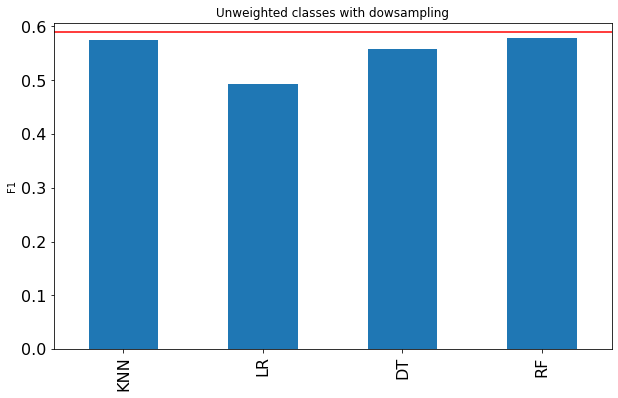

In [35]:
fig = pd.Series(data=[best_knn_d['f1_score'],
                best_lr_d['f1_score'],
                best_dt_d['f1_score'],
                best_rf_d['f1_score']],
                index=['KNN','LR','DT', 'RF']).plot(kind='bar', 
                                                    title="Unweighted classes with dowsampling",
                                                    fontsize=16,
                                                    figsize=(10,6))
fig.set_ylabel('F1');
plt.axhline(y = 0.59, color = 'r', linestyle = '-');

**Вывод** Техника Downsampling не оправдала себя. При таком простом методе могут быть потеряны наблюдения, несущие полезную информацию, поэтому повышается риск недообучения моделей.

### Upsampling увеличение выборки

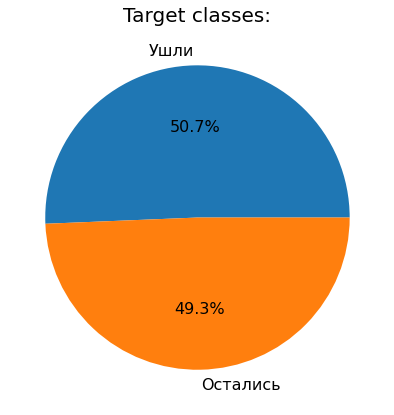

In [36]:
def upsample(features, target, repeat=4):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
fig = target_upsampled.value_counts().rename(index={1:"Ушли", 0:"Остались"}).plot(kind='pie', 
                                            title="Target classes:",
                                            fontsize=16,
                                            legend=False,
                                            autopct='%1.1f%%',
                                            figsize=(7,7))
fig.axes.title.set_size(20)
fig.axes.set_ylabel(None);

Дисбаланс устранён.

#### Метод k-ближайших соседей

In [37]:
parameters = {'n_neighbors':list(range(1,20))}
model = KNeighborsClassifier()
clf_knn_u = GridSearchCV(model, parameters, scoring='f1')
clf_knn_u.fit(features_upsampled, target_upsampled)
print(f"The best f1-score: {clf_knn_u.best_score_:.2%} for n_neighbors: {clf_knn_u.best_params_['n_neighbors']}")

The best f1-score: 93.26% for n_neighbors: 1


Вау-вау! Супер метод ближайших соседей достиг потрясающего значения метрики. Самая лучшая модель. Или...

На самом деле нет. Нужно обратить внимание на число соседей - 1. Это свидетельствует о сильном переобучении. Но почему F1-мера на кросс-проверки такая большая? А это потому что при кросс-проверке используются тоже дублированные сэмплы. Эта проблема возникает и при более продвинутых техниках upsampling и есть несколько выриантов борьбы с ней.
1) Отказаться для этой ситуации от GridSearchCV и перекрёстной проверки разделив выборку на обучающую и валидационную. Увеличить только обучающую. Подбирать параметры в цикле.

2) Отказаться для этой ситуации от GridSearchCV и написать функцию перекрёстной проверки с учётом upsampling. Подбирать параметры в цикле.

3) Использовать вспомогательные классы модели. (Из пакета imblearn например).

Попробуем реализовать второй способ.

In [38]:
score_tracker = []
parameters = {'n_neighbors':list(range(1,20))}
for n_neighbors in parameters['n_neighbors']:
    example_params = {
        'n_neighbors': n_neighbors,
    }
    example_params['f1_score'] = score_model(KNeighborsClassifier,example_params, upsample).mean()
    score_tracker.append(example_params)
        
# What's the best model?
best_knn_u = sorted(score_tracker, key=lambda x: x['f1_score'], reverse=True)[0]
best_knn_u

{'n_neighbors': 16, 'f1_score': 0.5717311980719859}

Вот теперь всё более реально.

#### Логистическая регрессия

In [39]:
parameters = {"random_state":[12345], 'C':list(np.logspace(-3, 4, 8))}
score_tracker = []
for c in parameters['C']:
    example_params = {
        'C': c,
        "random_state": 12345
    }
    example_params['f1_score'] = score_model(LogisticRegression, example_params, upsample).mean()
    score_tracker.append(example_params)
        
# What's the best model?
best_lr_u = sorted(score_tracker, key=lambda x: x['f1_score'], reverse=True)[0]
best_lr_u

{'C': 0.01, 'random_state': 12345, 'f1_score': 0.49503933733040845}

Примерно одинаково, как  при downsampling так и при взвешенных классах.

#### Решающее дерево

In [40]:
parameters = {"random_state":[12345], 'max_depth':list(range(1, 20))} 
score_tracker = []
for max_depth in parameters['max_depth']:
    example_params = {
        'max_depth': max_depth,
        "random_state": 12345
    }
    example_params['f1_score'] = score_model(DecisionTreeClassifier, example_params, upsample).mean()
    score_tracker.append(example_params)
        
# What's the best model?
best_dt_u = sorted(score_tracker, key=lambda x: x['f1_score'], reverse=True)[0]
best_dt_u

{'max_depth': 6, 'random_state': 12345, 'f1_score': 0.5711716035372119}

Лучше, чем при взвешенных классах и при downsampling.

#### Случайный лес

In [41]:
parameters = {"random_state":[12345], 
              'max_depth':list(range(1, 15)), 
              'n_estimators':[50, 100, 200, 350]}
score_tracker = []
for n_estimators in parameters['n_estimators']:
    for max_depth in parameters['max_depth']:
        example_params = {
            'max_depth': max_depth,
            "random_state": 12345,
            "n_estimators": n_estimators
        }
        example_params['f1_score'] = score_model(RandomForestClassifier, example_params,upsample).mean()
        score_tracker.append(example_params)
        
# What's the best model?
best_rf_u = sorted(score_tracker, key=lambda x: x['f1_score'], reverse=True)[0]
best_rf_u

{'max_depth': 12,
 'random_state': 12345,
 'n_estimators': 50,
 'f1_score': 0.6039138264424277}

Впринципе довольно хорошая модель по метрики, но не дотягивает до такой же при взвешенных классах.

#### Сравнение лучших моделей по F1

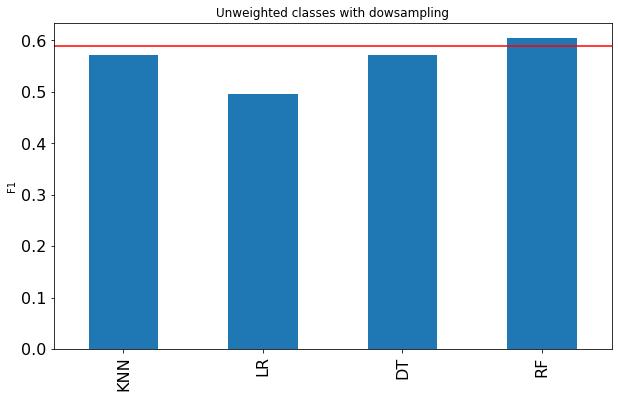

In [42]:
fig = pd.Series(data=[best_knn_u['f1_score'],
                best_lr_u['f1_score'],
                best_dt_u['f1_score'],
                best_rf_u['f1_score']],
                index=['KNN','LR','DT', 'RF']).plot(kind='bar', 
                                                    title="Unweighted classes with dowsampling",
                                                    fontsize=16,
                                                    figsize=(10,6))
fig.set_ylabel('F1');
plt.axhline(y = 0.59, color = 'r', linestyle = '-');

**Вывод** При кросс-валидации результаты по метрики получились лучше, чем при downsampling, но так ли это на самом деле решим при тестировании на тестовом наборе. Тестировать будем лучшие модели - деревья решений.

## Тестирование модели

In [43]:
plt.rcParams["figure.figsize"] = (10,10)
def roc_plot(target_valid, features_valid, model):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    plt.plot(fpr, tpr, linestyle='-')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel('True Positive Rate')
    plt.title("ROC-кривая")

### Базовая линия

The baseline F1-score: 0.00%
The baseline AUC-ROC-score: 50.00%


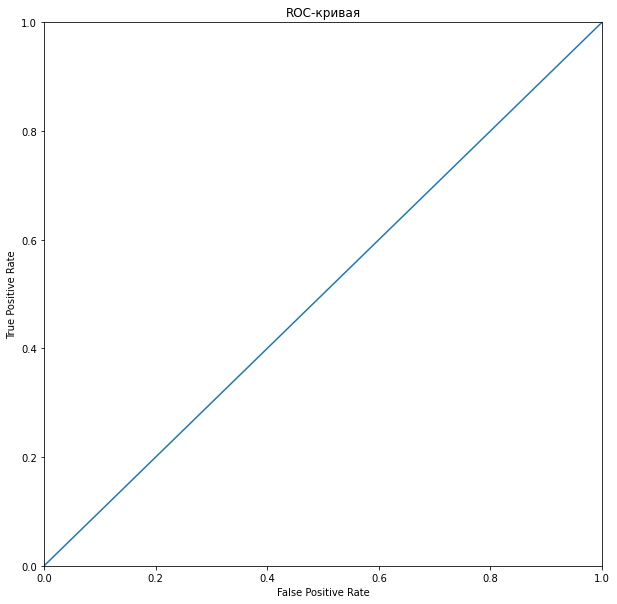

In [44]:
predicted_test = model_bl.predict(features_test)
print(f"The baseline F1-score: {f1_score(target_test, predicted_test):.2%}")
print(f"The baseline AUC-ROC-score: {roc_auc_score(target_test, model_bl.predict_proba(features_test)[:, 1]):.2%}")
roc_plot(target_test, features_test, model_bl)

Соответствует случайной модели.

### Модель  с взвешенными классами

The weighted classes RF F1-score: 60.69%
The weighted classes RF AUC-ROC-score: 85.92%


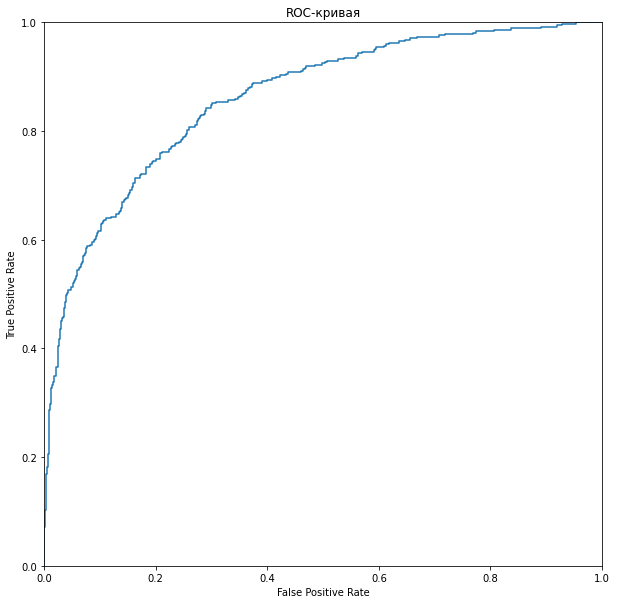

In [45]:
model_best = clf_rf_w.best_estimator_
predicted_test = model_best.predict(features_test)
print(f"The weighted classes RF F1-score: {f1_score(target_test, predicted_test):.2%}")
print(f"The weighted classes RF AUC-ROC-score: {roc_auc_score(target_test, model_best.predict_proba(features_test)[:, 1]):.2%}")
roc_plot(target_test, features_test, model_best)

**Достаточно высокое значение как F1-меры так и AUC.**

### Модель с простым увеличением выборки

The upsampling RF F1-score: 60.76%
The upsampling RF AUC-ROC-score: 85.83%


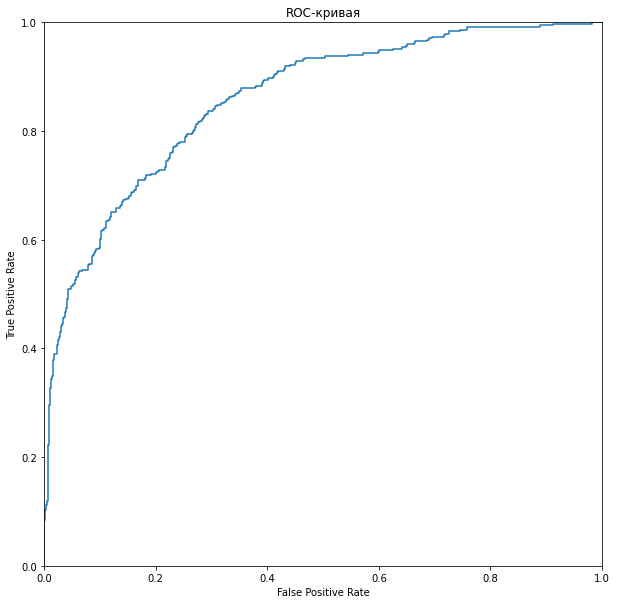

In [46]:
model_best=RandomForestClassifier(max_depth=12, random_state=12345, n_estimators=200)
model_best.fit(features_upsampled, target_upsampled)
predicted_test = model_best.predict(features_test)
print(f"The upsampling RF F1-score: {f1_score(target_test, predicted_test):.2%}")
print(f"The upsampling RF AUC-ROC-score: {roc_auc_score(target_test, model_best.predict_proba(features_test)[:, 1]):.2%}")
roc_plot(target_test, features_test, model_best)

**И F1 и AUC-ROC хуже, чем у модели со взвешенными классами. Может в будущем следует попробовать более продвинутые варианты Upsampling.**

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*